# Merge added buildings with tree canopy changes

Summarize the qualities of the tree canopy changes for the footprints of the added buildings.

In [13]:
import fiona
from pathlib import Path
import rasterio
import rasterio.mask
import numpy as np

In [10]:
buildings_added_shapefile = Path("building_added", "building_added.shp")

canopy_diff_rasterfile = Path("CanopyDiff.tif")

The new file we'll write merged data to

In [22]:
buildings_canopy_shapefile = Path("buildings_canopy", "buildings_canopy.shp")

buildings_canopy_shapefile.parent.mkdir(exist_ok=True)

In [23]:
canopy_diff_raster = rasterio.open(canopy_diff_rasterfile)

with fiona.open(buildings_added_shapefile) as source:
    schema = source.schema.copy()
    schema["properties"]["tree_sum"] = "float"
    print(schema)
    with fiona.open(buildings_canopy_shapefile, "w", 
                   driver=source.driver,
                   crs=source.crs,
                   schema=schema) as target:
        for index, feature in enumerate(source):
            if index % 100 == 0:
                print(index)
            properties = feature["properties"]
            geometry = feature["geometry"]
            geometries = [geometry] # rasterio wants a list of geometries
            
            # mask the raster using the feature's polygon(s)
            raster_image, out_transformation = rasterio.mask.mask(canopy_diff_raster,
                                                                  geometries,
                                                                  crop=True)
            
            # summarize the pixels in that raster image
            #print(raster_image)
            trees = np.float32(raster_image[0, :, :])
            
            # update the schema with the computed data
            properties["tree_sum"] = float(np.sum(trees))
            
            # write the row to the output file
            target.write({"properties": properties,
                         "geometry": geometry})

{'properties': {'OBJECTID': 'int:11', 'BIN': 'str:7', 'FCODE': 'int:6', 'ADDRESS': 'str:39', 'BUILDING_N': 'str:110', 'BASE_ELEVA': 'float:32.10', 'APPROX_HGT': 'int:6', 'MAX_HGT': 'float:32.10', 'PARCEL_ID_': 'str:10', 'PARCEL_I_1': 'str:3', 'SHAPE__ARE': 'float:32.10', 'SHAPE__LEN': 'float:32.10', 'tree_sum': 'float'}, 'geometry': 'Polygon'}
0
100
200


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

300
400
500
600


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

700
800
900
1000


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

1100
1200
1300
1400


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

1500
1600
1700
1800


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

1900
2000
2100
2200
2300


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

2400
2500
2600
2700
2800


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

2900
3000
3100
3200


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

3300
3400
3500
3600
3700


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

3800
3900
4000
4100
4200


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

4300
4400
4500
4600
4700


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

4800
4900
5000
5100
5200


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

5300
5400
5500
5600
5700


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

5800
5900
6000
6100
6200


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

6300
6400
6500
6600
6700


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

6800
6900
7000
7100
7200


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

7300
7400
7500
7600
7700


/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  properties["tree_sum"] = float(np.sum(trees))
/var/folders/v5/glvyn5b516v0py1ccs07klph0000gp/T/ipykernel_57936/3326439218.py:28: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona vers

In [5]:
ls

CanopyDiff.tif          buildings/              explore.sql
LI_BUILDING_FOOTPRINTS/ buildings-canopy.ipynb  readme.md
PhilaBuildings2017/     canopyDiff.js
building_added/         city_limit/


Read the new shapefile and build a histogram

In [25]:
# from geopandas import GeoDataFrame as gdf
import geopandas as gpd

In [34]:
gdf = gpd.read_file(buildings_canopy_shapefile)

array([[<Axes: title={'center': 'tree_sum'}>]], dtype=object)

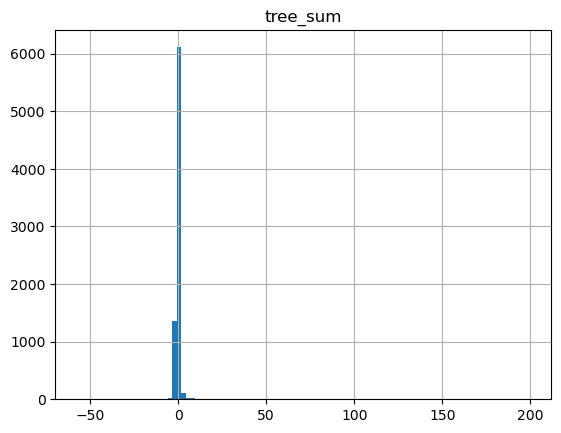

In [32]:
gdf.hist(column="tree_sum", bins=100)